# Importing Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,re,h5py
import time
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten,Conv2D,MaxPooling2D, Dropout,BatchNormalization,ZeroPadding2D,Concatenate,Input
from keras.models import Model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.utils import shuffle


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [3]:
PATH = "/content/drive/MyDrive/minor_gans/chest_xray"
METRICS_PATH="/content/drive/MyDrive/minor_gans/output/alexnet/"
MODEL_NAME="AlexNet"
print("PWD", PATH)

PWD /content/drive/MyDrive/minor_gans/chest_xray


# Define Metrics

In [4]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [5]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [6]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from drive

In [7]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [8]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['NORMAL', 'PNEUMONIA']


In [9]:
img_data_list = []

for dataset in data_dir_list:
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x/255
        img_data_list.append(x)


Loaded the images of dataset-NORMAL

Loaded the images of dataset-PNEUMONIA



In [10]:
img_data = np.array(img_data_list)
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(5857, 1, 32, 32, 3)
(1, 5857, 32, 32, 3)
(5857, 32, 32, 3)


# Train and Test Data

In [11]:
num_classes = 2
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:1584] = 0
labels[1584:] = 1
names = ['NORMAL', 'PNEUMONIA']

sample 5857


In [12]:
Y = np_utils.to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [13]:
model = Sequential()
model.add(ZeroPadding2D(1, input_shape=(32,32,3)))
model.add(Conv2D(96, (5,5), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3, name='dropout_1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='block1_maxpooling2'))
model.add(Conv2D(384, (3, 3), activation='relu', name='block1_conv3', padding='same'))

model.add(Conv2D(384, (3, 3), activation='relu', name='block1_conv4', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', name='block1_conv5', padding='same'))
model.add(Dropout(0.4, name='dropout_2'))
model.add(Flatten(name='flatten'))
# model.add(Dense(512, activation='relu', name='fc'))
# model.add(Dropout(0.5, name='dropout_3'))
model.add(Dense(4096, activation='relu', name='fc2'))
model.add(Dropout(0.5, name='dropout_4'))
model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dropout(0.5, name='dropout_5'))
model.add(Dense(2, activation='softmax', name='predictions'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 34, 34, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 96)        7296      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+'.csv', append=True, separator=';')

adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.99, epsilon=None, decay=1e-6, amsgrad=False)


# Let's train the model using Adam
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy', f1, sensitivity, specificity])


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Model Training

### With Augumentation

In [ ]:
batch_size = 16
data_augmentation = True
epochs = 100

In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Using real-time data augmentation.


<ipython-input-16-eb7f1dcb9614>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/100
1378/1378 [==============================] - 107s 69ms/step - loss: 0.3504 - accuracy: 0.8482 - f1: 0.8481 - sensitivity: 0.8481 - specificity: 0.8481 - val_loss: 0.1633 - val_accuracy: 0.9447 - val_f1: 0.9449 - val_sensitivity: 0.9449 - val_specificity: 0.9449 - lr: 6.0000e-05
Epoch 2/100
1378/1378 [==============================] - 93s 68ms/step - loss: 0.1771 - accuracy: 0.9444 - f1: 0.9444 - sensitivity: 0.9444 - specificity: 0.9444 - val_loss: 0.1490 - val_accuracy: 0.9514 - val_f1: 0.9516 - val_sensitivity: 0.9516 - val_specificity: 0.9516 - lr: 6.0000e-05
Epoch 3/100
1378/1378 [==============================] - 93s 67ms/step - loss: 0.1616 - accuracy: 0.9499 - f1: 0.9499 - sensitivity: 0.9499 - specificity: 0.9499 - val_loss: 0.1539 - val_accuracy: 0.9530 - val_f1: 0.9532 - val_sensitivity: 0.9532 - val_specificity: 0.9532 - lr: 6.0000e-05
Epoch 4/100
1378/1378 [==============================] - 93s 67ms/step - loss: 0.1495 - accuracy: 0.9532 - f1: 0.9532 - sensitivi

In [ ]:
print('------------Training time is seconds:%s',time.time()-start_time)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 10318.08790898323
173/173 [==============================] - 2s 14ms/step - loss: 21.0180 - accuracy: 0.7066 - f1: 0.7057 - sensitivity: 0.7057 - specificity: 0.7057
dict_keys(['loss', 'accuracy', 'f1', 'sensitivity', 'specificity', 'val_loss', 'val_accuracy', 'val_f1', 'val_sensitivity', 'val_specificity', 'lr'])
dict_values([[0.3504314124584198, 0.1770816594362259, 0.1616358608007431, 0.14949189126491547, 0.12708188593387604, 0.12226053327322006, 0.11097189038991928, 0.11074025183916092, 0.10536908358335495, 0.10711054503917694, 0.10650721937417984, 0.10484899580478668, 0.10539739578962326, 0.10312582552433014, 0.10330159217119217, 0.10294536501169205, 0.10313361883163452, 0.10306428372859955, 0.10363636910915375, 0.10388538241386414, 0.10356530547142029, 0.10252772271633148, 0.09905999898910522, 0.10388176143169403, 0.1014794409275055, 0.10235633701086044, 0.10116755962371826, 0.10266046971082687, 0.10518509894609451, 0.10172433406114578, 0.10

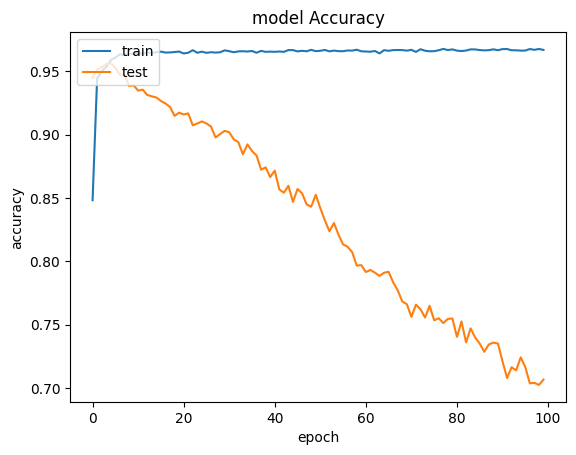

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

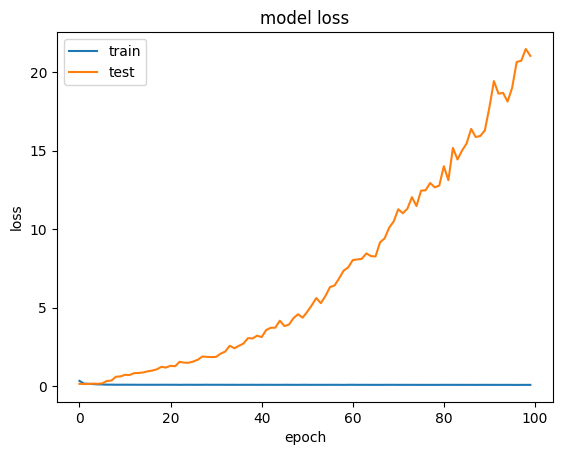

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


### Without Augumentation

In [ ]:
MODEL_NAME="AlexNet_waug"

In [ ]:
batch_size = 16
data_augmentation = False
epochs = 100

In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Not using data augmentation.
Epoch 1/100
1378/1378 [==============================] - 91s 66ms/step - loss: 0.0894 - accuracy: 0.9685 - f1: 0.9685 - sensitivity: 0.9685 - specificity: 0.9685 - val_loss: 22.8326 - val_accuracy: 0.6818 - val_f1: 0.6815 - val_sensitivity: 0.6815 - val_specificity: 0.6815 - lr: 5.0000e-07
Epoch 2/100
1378/1378 [==============================] - 94s 68ms/step - loss: 0.0886 - accuracy: 0.9692 - f1: 0.9692 - sensitivity: 0.9692 - specificity: 0.9692 - val_loss: 25.6313 - val_accuracy: 0.6678 - val_f1: 0.6674 - val_sensitivity: 0.6674 - val_specificity: 0.6674 - lr: 5.0000e-07
Epoch 3/100
1378/1378 [==============================] - 91s 66ms/step - loss: 0.0864 - accuracy: 0.9691 - f1: 0.9691 - sensitivity: 0.9691 - specificity: 0.9691 - val_loss: 26.0948 - val_accuracy: 0.6702 - val_f1: 0.6697 - val_sensitivity: 0.6697 - val_specificity: 0.6697 - lr: 5.0000e-07
Epoch 4/100
1378/1378 [==============================] - 90s 66ms/step - loss: 0.0856 - accuracy: 

In [ ]:
print('------------Training time is seconds:%s',time.time()-start_time)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 10770.653259277344
173/173 [==============================] - 3s 15ms/step - loss: 402.7080 - accuracy: 0.4811 - f1: 0.4818 - sensitivity: 0.4818 - specificity: 0.4818
dict_keys(['loss', 'accuracy', 'f1', 'sensitivity', 'specificity', 'val_loss', 'val_accuracy', 'val_f1', 'val_sensitivity', 'val_specificity', 'lr'])
dict_values([[0.08942694962024689, 0.08864688873291016, 0.08643587678670883, 0.08564142137765884, 0.08532015234231949, 0.08400390297174454, 0.08458738774061203, 0.08392436057329178, 0.08351994305849075, 0.0820915699005127, 0.08388631045818329, 0.08246615529060364, 0.08151032775640488, 0.07992131263017654, 0.07952248305082321, 0.07975181937217712, 0.0794324055314064, 0.07739996165037155, 0.07945114374160767, 0.07904235273599625, 0.07835706323385239, 0.07742173224687576, 0.07641277462244034, 0.07627701014280319, 0.07482398301362991, 0.07475732266902924, 0.07494533061981201, 0.0756075531244278, 0.0736338272690773, 0.07251577079296112, 0.

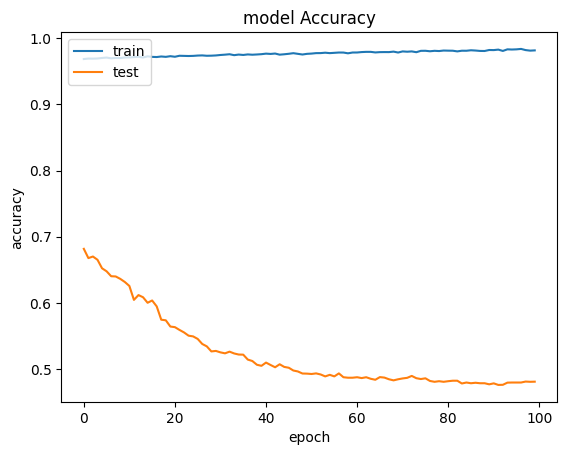

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

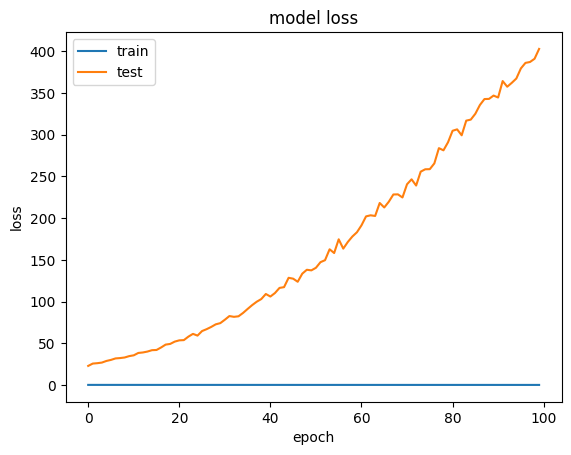

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()
